# The Hadamard Attack and Random Queries

In [1]:
# AGENCY CODE

import numpy as np

class Agency:
    """
    This class acts as the service, also known as the agency,
    which holds the secret vector x and responds with fractional answers to query workloads
    Gaussian noise will be added to responses
    """
    def __init__(self, n, sigma):
        """
        n: the size of the secret binary vector (length = number of entries)
        sigma: standard deviation of gaussian noise in each response
        """
        
        # Generate 
        self._n = n
        self._x = np.random.randint(2, size=self._n)
        self._s = sigma
    
    @property
    def n(self):
        return self._n
    
    def query(self, B):
        """
        Input
            B: workload (must be a matrix of width n)
        Output
            1/n B @ x, with gaussian noise added, mean 0, stddev sigma
        """
        
        assert(len(B.shape) == 2 and B.shape[1] == self._n)
        return B @ self._x / self._n + np.random.normal(0, self._s, B.shape[0]).T
    
    def guess(self, x1):
        """
        Input
            x1: Vector you guess to be secret vector
        Output
            Honest answer of fraction of correct bits in x
        """
        return np.count_nonzero(self._x == x1) / self._n

In [2]:
# ATTACK CODE

from scipy.linalg import hadamard

def attack_hadamard(agcy):
    """
    Attack the agency with a Hadamard workload of the same size
    
    Input
        agcy: Agency to attack
    Output
        estimate of agency's secret vector
    """
    
    H = hadamard(agcy.n)
    a = agcy.query(H)
    z = H @ a
    return round_zero_one(z)

def attack_random(agcy, m):
    """
    Attack the agency with a random workload of the same size width but variable length
    
    Input
        agcy: Agency to attack
        m: Number of entries in random workload
    Output
        estimate of agency's secret vector
    """
    
    B = np.random.randint(2, size=(m, agcy.n))
    a = agcy.query(B)
    z = np.linalg.lstsq((B / agcy.n), a)[0]
    return round_zero_one(z)

# UTILITIES

# Create a vectorized method to compute whether each value is nearer to 0 or 1
rounder = lambda t: 1 if t >= 0.5 else 0
round_zero_one = np.vectorize(rounder)

In [3]:
# TEST SUITE

# Controls
k = 20
n_values = [128, 512, 2048, 8192]
m_coef = [1.1, 4, 16]
h_scores = []
b_scores = []

# Hadamard attack test
for n in n_values:
    sigma = 1 / 2
    h_scores.append([])
    # Test every sigma on a negative power of 2 down to 1 / sqrt(32n)
    while sigma > 1 / np.sqrt(32 * n):
        h_scores[-1].append([])
        for i in range(k):
            ag = Agency(n, sigma)
            x1 = attack_hadamard(ag)
            score = ag.guess(x1)
            h_scores[-1][-1].append(score)
        sigma /= 2

In [52]:
# Random attack test (parameters taken as inputs so we can limit test space if necessary)
def do_random_run(n, m, sigma):
    scores = []
    for i in range(k):
        ag = Agency(n, sigma)
        x2 = attack_random(ag, m)
        score = ag.guess(x2)
        scores.append(score)
    print(scores)

In [61]:
import math

# Split into individual runs because of the gargantuan memory requirements of the random workload
for n in n_values:
    if n == 2048:
        # Limit the sigmas for larger n
        sig = []
        if n == 128:
            sig = [1,2,3,4,5]
        elif n == 512:
            sig = [1,2,3,4,5,6]
        elif n == 2048:
            sig = [1,3,5,7]
        for m in m_coef:
            for s in sig:
                do_random_run(n, int(m * n),  1 / math.pow(2, s))

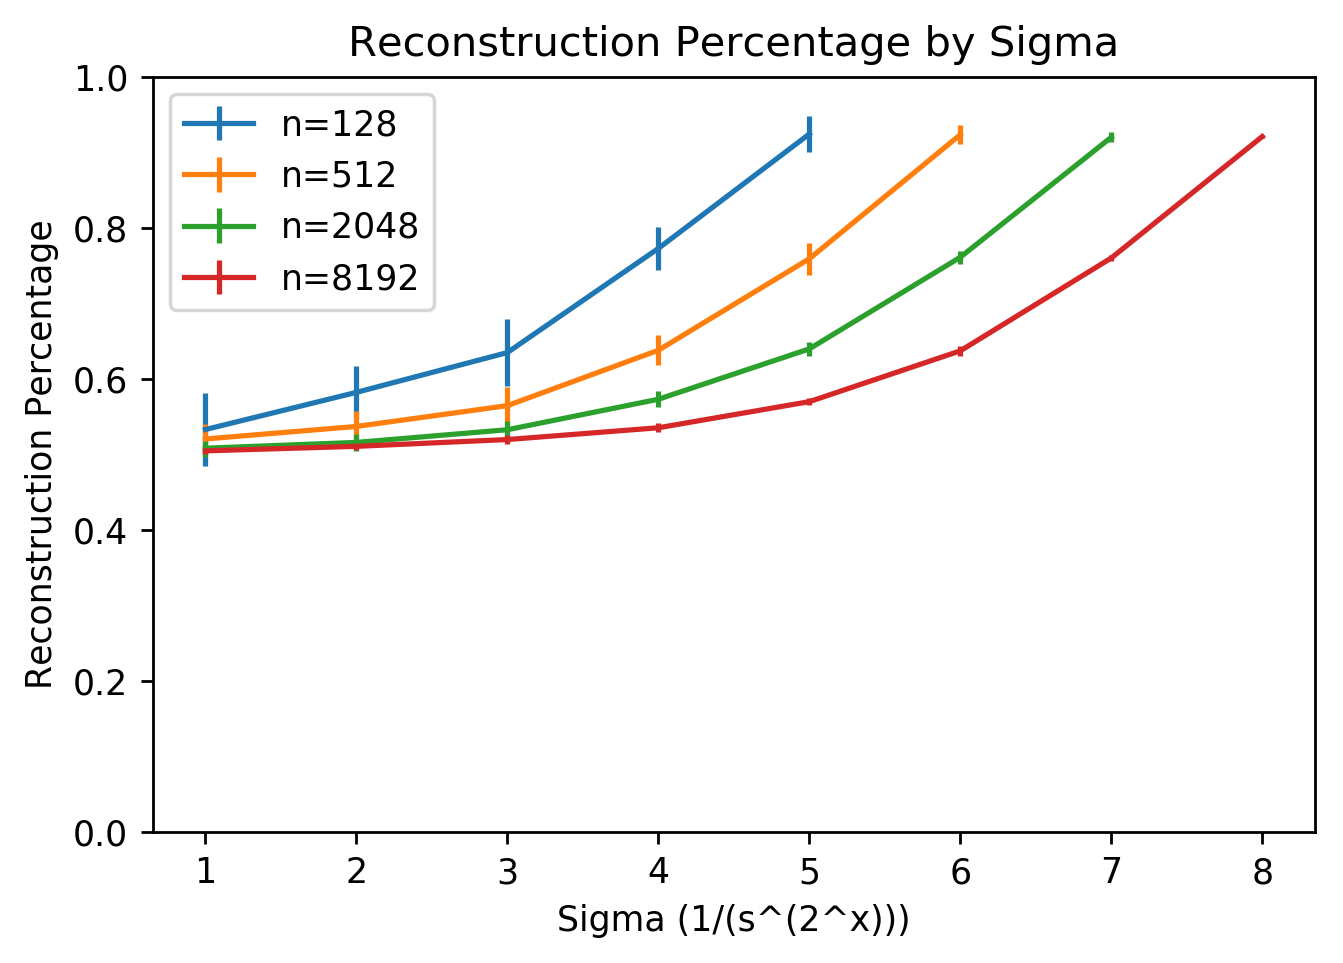

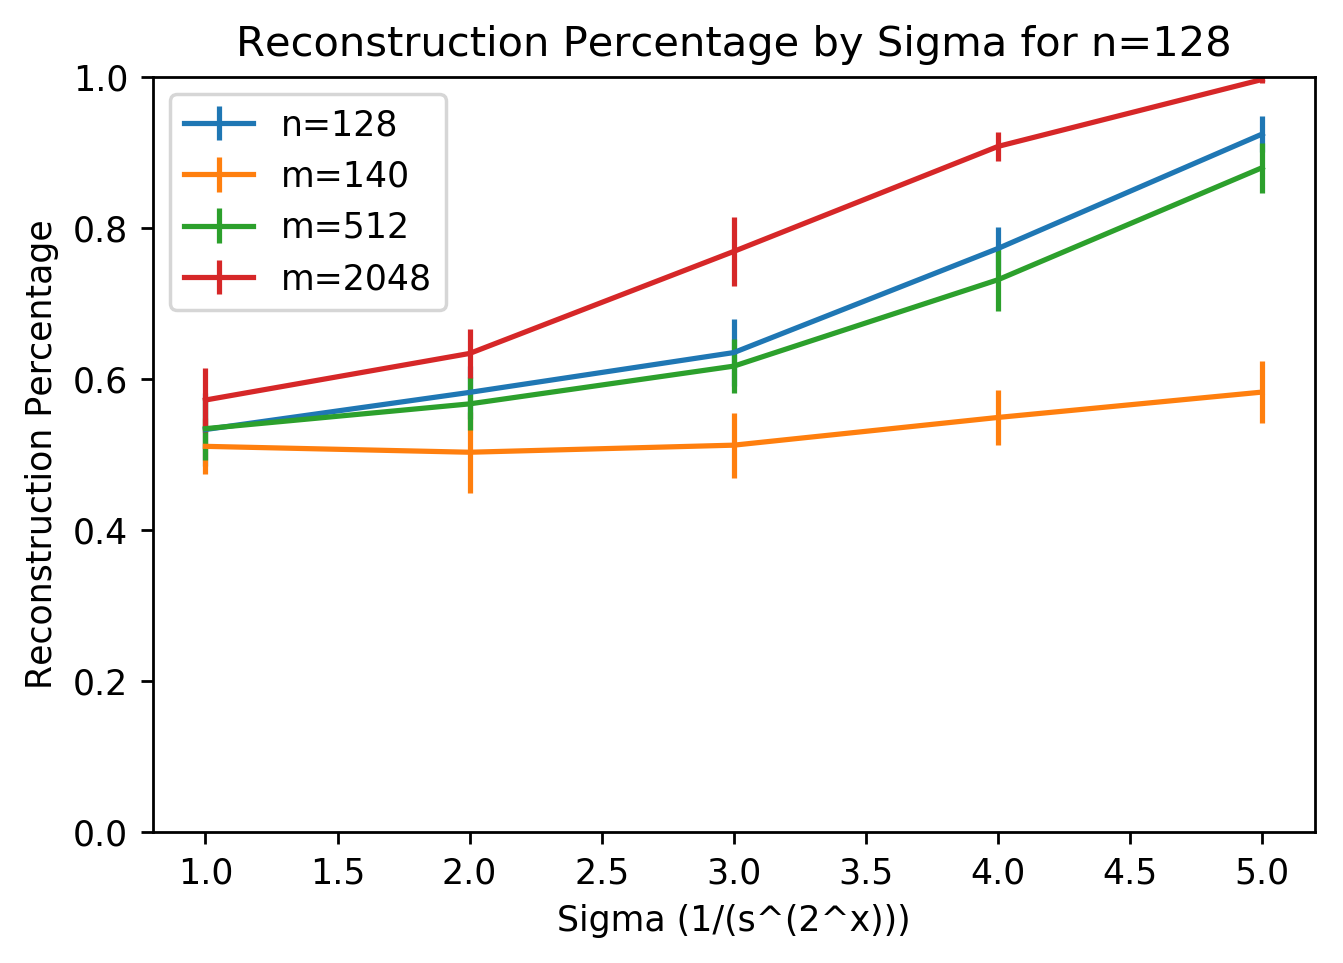

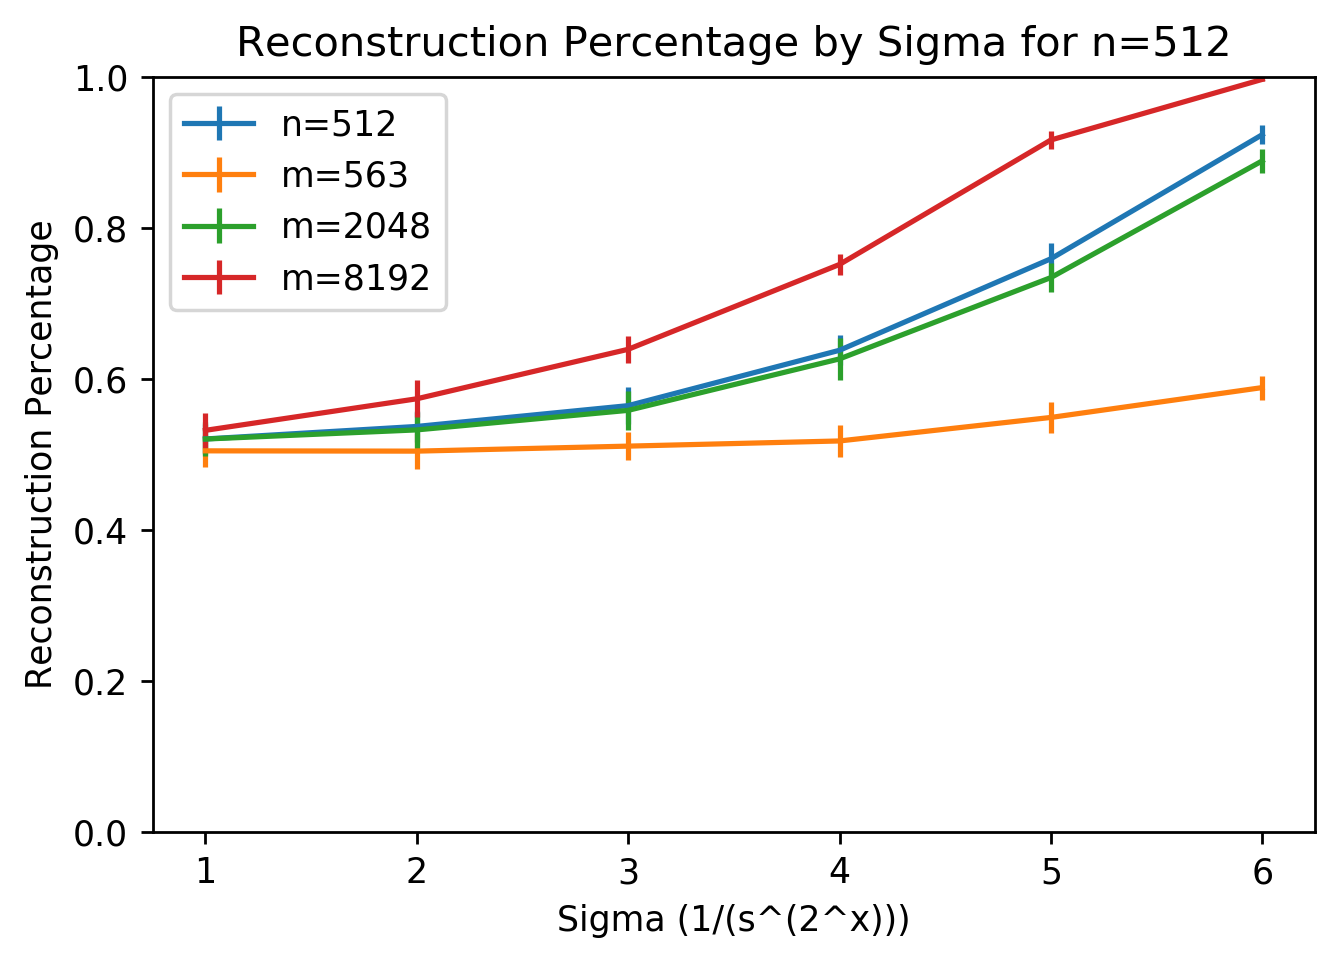

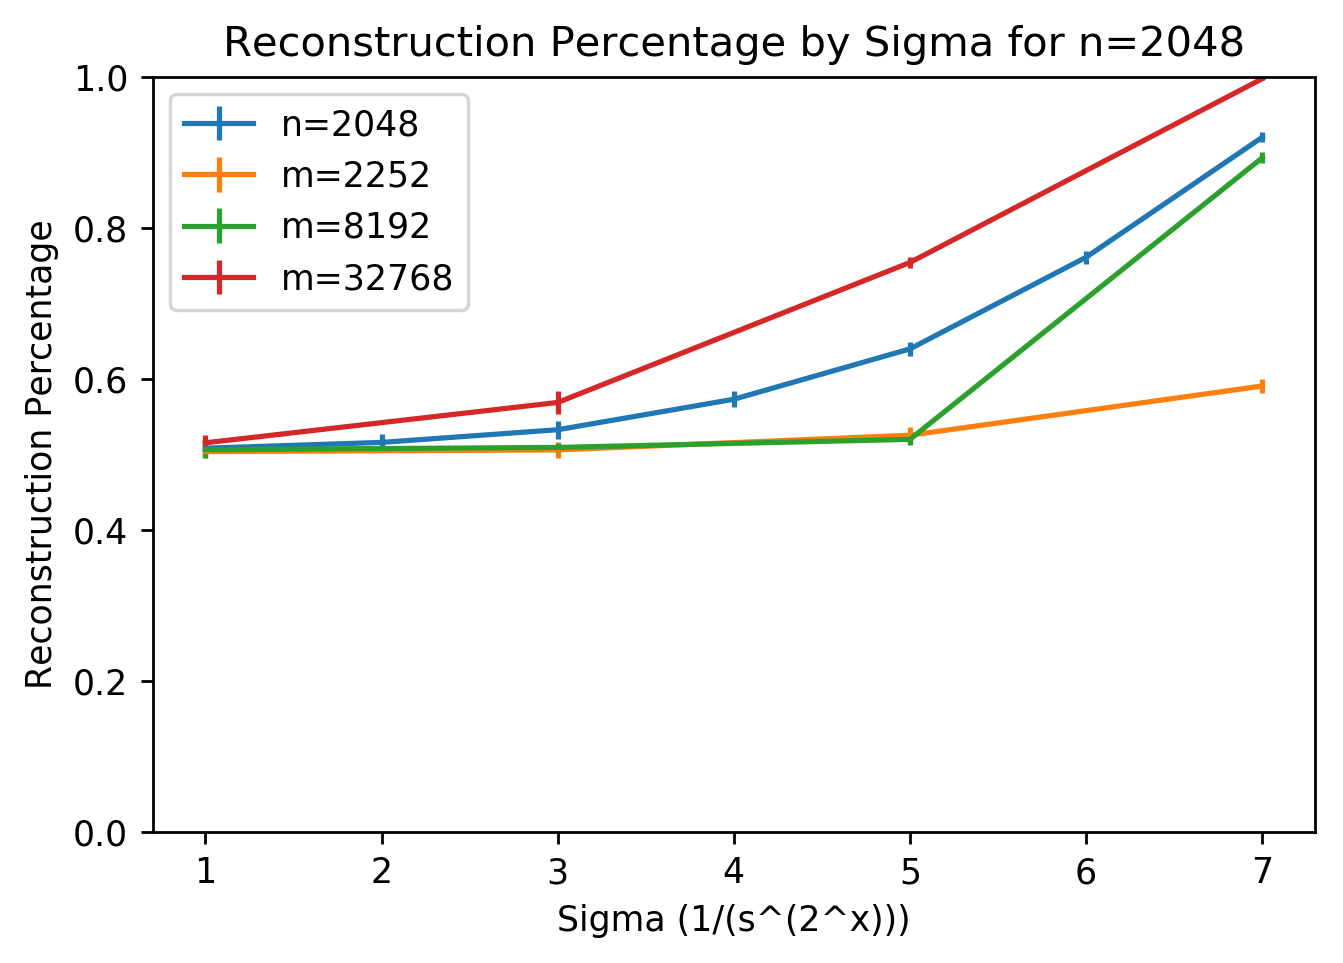

In [60]:
import matplotlib
import matplotlib.pyplot as plt

# Reconstruction Percentage by N
plt.figure(dpi=250)
for i in range(len(n_values)):
    x = 1
    X = []
    Y = []
    err = []
    for scores in h_scores[i]:
        X.append(x)
        Y.append(np.mean(scores))
        err.append(np.std(scores))
        x += 1
    plt.errorbar(X, Y, yerr=err, label='n={:d}'.format(n_values[i]))
plt.plot()
plt.xlabel('Sigma (1/(s^(2^x)))')
plt.ylabel('Reconstruction Percentage')
plt.ylim((0, 1))
plt.title("Reconstruction Percentage by Sigma")
plt.legend()
plt.show()

# plot fraction per sigma per m compared with n
for i in range(len(n_values)):
    if i >= len(b_scores):
        break
    x = 1
    X = []
    Y = []
    err = []
    plt.figure(dpi=250)
    for scores in h_scores[i]:
        X.append(x)
        Y.append(np.mean(scores))
        err.append(np.std(scores))
        x += 1
    plt.errorbar(X, Y, yerr=err, label='n={:d}'.format(n_values[i]))
    j = 0
    for m in [int(mc * n_values[i]) for mc in m_coef]:
        x = 1
        X = []
        Y = []
        err = []
        for scores in b_scores[i][j]:
            X.append(x)
            Y.append(np.mean(scores))
            err.append(np.std(scores))
            x += 1
            if i == 2: # This is just because for n = 2048 I did odd powers of 2 to save time
                x += 1
        plt.errorbar(X, Y, yerr=err, label='m={:d}'.format(m))
        j += 1
    plt.xlabel('Sigma (1/(s^(2^x)))')
    plt.ylabel('Reconstruction Percentage')
    plt.ylim((0, 1))
    plt.title("Reconstruction Percentage by Sigma for n={:d}".format(n_values[i]))
    plt.legend()
    plt.show()